In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from dotenv import load_dotenv

load_dotenv()
import os

import sqlite3

DB_PATH = os.getenv("DB_PATH")
DATA_PATH = "data"

conn = sqlite3.connect(DB_PATH)

data = pd.read_csv('../unseen_species_model/estimations-per-region-3072023.csv')
data = data[data['decade']<=1840]

df_score_region = pd.read_sql_query("SELECT * FROM region_score", conn)
df_score_region = df_score_region.rename(columns = {'region_name':'region'})

new_df = pd.merge(data, df_score_region, on = ['decade', 'region'])
new_df = new_df.rename(columns = {'region':'region_name', 'decade':'year'})
new_df['year'] = new_df['year'].astype(int)
new_df['year'] = new_df['year'].apply(lambda x: round(x/10)*10)
new_df = new_df.groupby(['region_name', 'year']).mean().reset_index()
new_df = new_df[new_df['year']<=1840]

In [3]:
import statsmodels.api as sm

In [4]:
def plot_trend(decades, scores, N_est, lower, upper, color="C0", label=None, ax=None, logy=False, figsize=None, lowess = True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    
    if lowess:
        
            # Add LOWESS regression lines
        lowess_scores = sm.nonparametric.lowess(scores, decades, frac=lowess_span)
        ax.plot(decades, lowess_scores[:, 1], color='black', label='LOWESS Scores')

        lowess_lower = sm.nonparametric.lowess(lower, decades, frac=lowess_span)
        lowess_upper = sm.nonparametric.lowess(upper, decades, frac=lowess_span)

        lowess_N_est = sm.nonparametric.lowess(N_est, decades, frac=lowess_span)
        ax.plot(decades, lowess_N_est[:, 1], color="C0", label='LOWESS N_est')

        ax.fill_between(decades, lowess_lower[:, 1], lowess_upper[:, 1], alpha=0.4, color=color)

    else:
        # Plot predicted line
        ax.plot(decades, N_est, color=color, label='Estimated diversity')
        ax.plot(decades, scores, color='black', label='Raw index')

    # Plot credibility bands
        ax.fill_between(decades, lower, upper, alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Number of Individuals")
    if logy:
        ax.set_yscale("log")
        
    ax.set_title(label)
    ax.legend()

    return ax

(-500.0, 1840.0)

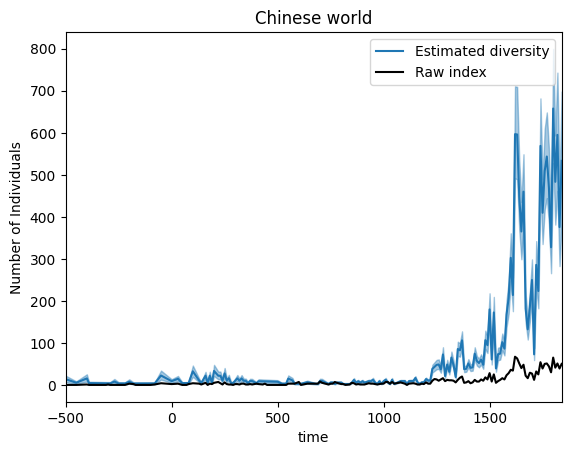

In [5]:
lowess_span = 0.05

region = 'Chinese world'

df = new_df[new_df['region_name']==region]

N_est = list(df['N_est'])
lower = list(df['lower'])
upper = list(df['upper'])
decades = list(df['year'])
scores = list(df['score'])


ax = plot_trend(decades, scores, N_est, lower, upper, label=region, logy = False, lowess = False)
ax.set_xlim(-500, 1840)

In [6]:
df_gdp = pd.read_sql_query("SELECT * FROM gdp", conn)
df_gdp = df_gdp.drop(['region_code', 'country_code_maddison'], axis=1)


df_population = pd.read_sql_query("SELECT * FROM population", conn)
df_population = df_population.drop('region_code', axis=1)

In [7]:
def interpolate_function(df, value="value", category="region_code", year="year", size_interpolation = 10):
    df_interpolated_list = []
    for reg in set(df[category]):
        res = df[df[category] == reg]

        min_date = min(res["year"])
        max_date = max(res["year"])

        year_range = np.arange(round(min_date), round(max_date), size_interpolation)
        df_year = pd.DataFrame(year_range, columns=[year]).reset_index(drop=True)

        res = pd.merge(res, df_year, on=year, how="outer")
        res[category] = reg
        res = res.sort_values(year, ascending=True)
        res[f"{value}_interpolated"] = res[value].interpolate(method="linear")
        res = res.reset_index(drop=True)
        res = res[~res[f"{value}_interpolated"].isna()]

        df_interpolated_list.append(res)

    df_interpolated = pd.concat([x for x in df_interpolated_list])
    df_interpolated = df_interpolated.reset_index(drop=True)
    df_interpolated = df_interpolated.drop(value, axis=1)

    return df_interpolated

In [8]:
# stats between index per capita and gdp_per_capita
# stats between N_est and gdp_per_capita

In [9]:
df_population_interpolation = interpolate_function(df_population, 
                                                   value = 'population', 
                                                   year = 'year', 
                                                   category="region_name",
                                                   size_interpolation = 10)

In [10]:
final = pd.merge(df_population_interpolation, new_df, on = ['region_name', 'year'])
final['score_cap'] = final['score']/final['population_interpolated']
final['lower_cap'] = final['lower']/final['population_interpolated']
final['N_est_cap'] = final['N_est']/final['population_interpolated']
final['upper_cap'] = final['upper']/final['population_interpolated']

years = np.arange(-1000, 1840, 1)


In [11]:
concat_list = []

for region in final.region_name.unique():
    df_years = pd.DataFrame(years, columns = ['year'])
    df_years['region_name'] = region
    
    mix = pd.merge(df_years, final, on = ['year', 'region_name'], how = 'outer')
    concat_list.append(mix)
    
new_final = pd.concat(concat_list)
new_final = new_final.sort_values(['region_name', 'year'])


new_final = new_final.set_index('year')
grouped = new_final.groupby('region_name')

In [12]:
interpolated_data = []
for name, group in grouped:
    interpolated_group = group.interpolate(method='linear')
    interpolated_data.append(interpolated_group)

# Concatenate the interpolated data for all regions
interpolated_df = pd.concat(interpolated_data)

# Reset the index to restore the 'year' column
interpolated_df = interpolated_df.reset_index()
interpolated_df = interpolated_df.drop_duplicates().dropna()

In [13]:
interpolated_df[interpolated_df['region_name']=='Latin World']

,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,upper_cap
60679,-350,Latin World,4.250,7.981294,4.639593,11.688094,1.0,0.235294,1.091669,1.877952,2.750140
60698,-349,Latin World,4.255,7.971065,4.634518,11.674172,1.0,0.235033,1.089328,1.873592,2.743990
60699,-348,Latin World,4.260,7.960835,4.629443,11.660250,1.0,0.234771,1.086987,1.869232,2.737841
60700,-347,Latin World,4.265,7.950606,4.624368,11.646327,1.0,0.234510,1.084647,1.864872,2.731691
60701,-346,Latin World,4.270,7.940376,4.619293,11.632405,1.0,0.234248,1.082306,1.860512,2.725542
...,...,...,...,...,...,...,...,...,...,...,...
63926,1835,Latin World,23.202,4.759163,2.853217,6.873986,2.0,0.086199,0.122973,0.205119,0.296267
63927,1836,Latin World,23.202,4.759163,2.853217,6.873986,2.0,0.086199,0.122973,0.205119,0.296267
63928,1837,Latin World,23.202,4.759163,2.853217,6.873986,2.0,0.086199,0.122973,0.205119,0.296267
63929,1838,Latin World,23.202,4.759163,2.853217,6.873986,2.0,0.086199,0.122973,0.205119,0.296267


In [14]:
test = interpolated_df[interpolated_df['region_name']=='Greek World']

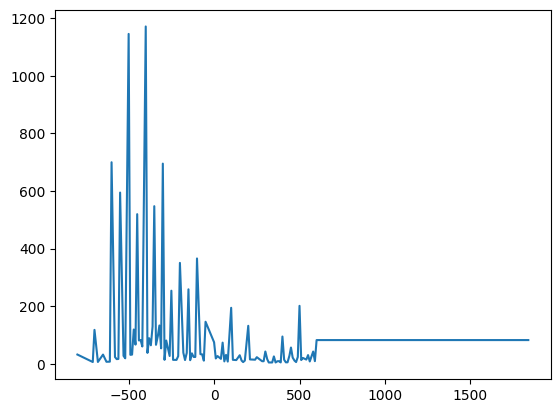

In [15]:
fig, ax = plt.subplots(figsize=None)
ax.plot(list(test['year']), list(test['N_est']), color='C0', label='Estimated diversity')

In [18]:
restricted = ['United Kingdom',
'Low countries',
'Italy',
'France',
'Eastern Europe',
'Nordic countries']

inclusive = ['United Kingdom',
'Low countries',
'Italy',
'France',
'Eastern Europe',
'Nordic countries',
'German world',
'Japan',
'Chinese world',
'Spain']

In [19]:
pd.options.mode.chained_assignment = None

In [20]:
df_stats = pd.merge(interpolated_df, df_gdp, on = ['region_name', 'year'])
df_stats_fil = df_stats[df_stats['region_name'].isin(inclusive)]
df_stats_fil['inclusive'] = '1'
df_stats_fil['restricted'] = np.nan
df_stats_fil['restricted'] [df_stats_fil['region_name'].isin(restricted)] = '1'
df_stats_fil['restricted'] [~df_stats_fil['region_name'].isin(restricted)] = '0'
df_stats_fil = df_stats_fil.reset_index(drop=True)

In [21]:
df_stats_fil.to_csv('../stats_correlation/data_stats_filtered.csv')
df_stats_fil.head(5)

,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,upper_cap,gdp_per_capita,inclusive,restricted
0,1000,Chinese world,60.0,9.868904,6.929422,13.257283,4.0,0.066667,0.115490,0.164482,0.220955,1225,1,0
1,1090,Chinese world,103.2,10.091769,7.589268,12.817687,5.5,0.054088,0.073662,0.097978,0.124495,1222,1,0
2,1120,Chinese world,114.2,10.269894,7.866837,12.838896,4.0,0.035026,0.068886,0.089929,0.112425,1181,1,0
3,1400,Chinese world,69.0,52.107474,42.550072,62.386230,10.0,0.144928,0.616668,0.755181,0.904148,1404,1,0
4,1410,Chinese world,73.1,41.634651,33.979611,49.851575,5.0,0.068399,0.464837,0.569557,0.681964,1414,1,0


In [ ]:
set(df_stats_fil.region_name)